Found 10 slice files
MLP: Vis_same_txt (Context) -> Diff: 0.9629, Ratio: 1.9447 (High: 1.9822, 2nd: 1.0192)
MLP: Vis_diff_txt (Parametric) -> Diff: 0.5188, Ratio: 1.3669 (High: 1.9327, 2nd: 1.4139)
MLP: Vis_same_txt (Parametric) -> Diff: 0.1015, Ratio: 1.0634 (High: 1.7015, 2nd: 1.6000)


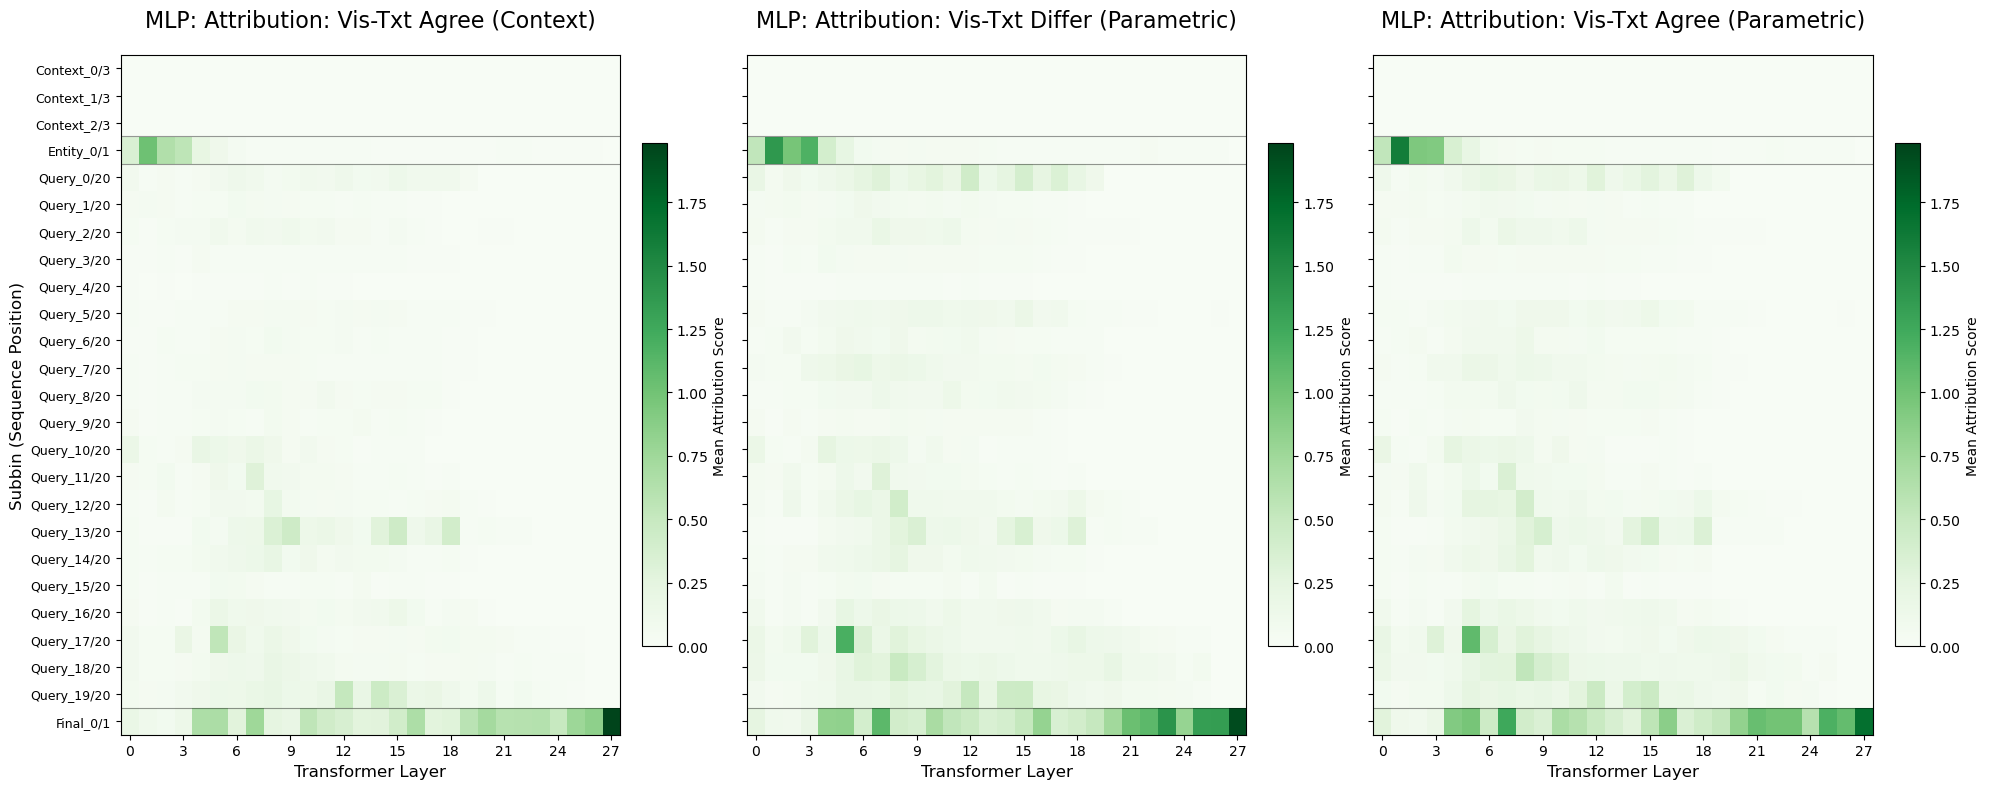

In [30]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_mlp.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
#df_vis_correct = df_all[(df_all["Group"] == "VisParam_TextCont") | (df_all["Group"] == "VisTxtParam")]
#df_others = df_all[(df_all["Group"] == "VisTxtCont") | (df_all["Group"] == "VisCont_TextParam")]
df_vis_correct = df_all[(df_all["Group"] == "VisParam_TxtCont")]
df_others = df_all[(df_all["Group"] == "VisTxtCont")]
df_vistxt_param = df_all[(df_all["Group"] == "VisTxtParam")]

mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)
mat_vistxt_param, labels_vistxt_param, info_vistxt_param = process_attribution_data(df_vistxt_param)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
cmap = "Greens" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis, mat_vistxt_param], 
    [labels_others, labels_vis, labels_vistxt_param], 
    [info_others, info_vis, info_vistxt_param], 
    ["Vis-Txt Agree (Context)", "Vis-Txt Differ (Parametric)", "Vis-Txt Agree (Parametric)"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    #2. Use global_vmax here for both subplots
    im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
                  cmap=cmap, vmin=0, vmax=global_vmax)
    # #POWER NORM SCALE#######
    # gamma = 0.3   # try 0.3–0.6

    # im = ax.imshow(
    #     A,
    #     aspect="auto",
    #     origin="upper",
    #     interpolation="nearest",
    #     cmap=cmap,
    #     norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    # )
    # ###################
    
    ax.set_title(f"MLP: Attribution: {title}", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    ratio = highest / second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff,
        "Ratio": ratio
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "MLP: Vis_same_txt (Context)")
mlp_diff_stats = get_top_two_analysis(mat_vis, "MLP: Vis_diff_txt (Parametric)")


print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f}, Ratio: {mlp_same_stats['Ratio']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f}, Ratio: {mlp_diff_stats['Ratio']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")
mlp_same_stats = get_top_two_analysis(mat_vistxt_param, "MLP: Vis_same_txt (Parametric)")
print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f}, Ratio: {mlp_same_stats['Ratio']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")

In [31]:
def get_bin_ratio_analysis(mat, info, group_name):
    """
    Calculates the ratio between the max attribution in 'Entity' 
    and the max attribution in the concluding tokens ('Last_token' or 'Final').
    """
    # 1. Map matrix rows back to their Bin labels using the info dataframe
    mat_with_info = mat.copy()
    mat_with_info['Bin'] = info['BinParsed'].values
    
    # 2. Extract max value for Entity
    entity_mask = mat_with_info['Bin'] == "Entity"
    if entity_mask.any():
        # Drop the 'Bin' column to calculate max across numeric layers only
        max_entity = mat_with_info[entity_mask].drop(columns='Bin').max().max()
    else:
        max_entity = 0

    # 3. Extract max value for Last_token or Final
    last_mask = mat_with_info['Bin'].isin(["Last_token", "Final"])
    if last_mask.any():
        max_last = mat_with_info[last_mask].drop(columns='Bin').max().max()
    else:
        max_last = 1e-9 # Prevent division by zero

    ratio = max_entity / max_last
    
    return {
        "Group": group_name,
        "Max_Entity": max_entity,
        "Max_Last": max_last,
        "Ratio": ratio
    }

# Execution
stats_list = [
    (mat_others, info_others, "Vis-Txt Agree (Context)"),
    (mat_vis, info_vis, "Vis-Txt Differ (Parametric)"),
    (mat_vistxt_param, info_vistxt_param, "Vis-Txt Agree (Parametric)")
]

print("--- Entity vs. Last Token Ratio Analysis ---")
for mat, info, name in stats_list:
    res = get_bin_ratio_analysis(mat, info, name)
    print(f"{res['Group']}:")
    print(f"  Max Entity: {res['Max_Entity']:.4f}")
    print(f"  Max Last/Final: {res['Max_Last']:.4f}")
    print(f"  Ratio (Entity/Last): {res['Ratio']:.4f}\n")

--- Entity vs. Last Token Ratio Analysis ---
Vis-Txt Agree (Context):
  Max Entity: 1.0192
  Max Last/Final: 1.9822
  Ratio (Entity/Last): 0.5142

Vis-Txt Differ (Parametric):
  Max Entity: 1.3806
  Max Last/Final: 1.9327
  Ratio (Entity/Last): 0.7144

Vis-Txt Agree (Parametric):
  Max Entity: 1.6000
  Max Last/Final: 1.7015
  Ratio (Entity/Last): 0.9403



Found 10 slice files
MLP: Vis_same_txt (Context) -> Diff: 0.0855, Ratio: 1.1470 (High: 0.6666, 2nd: 0.5812)
MLP: Vis_diff_txt (Parametric) -> Diff: 0.4559, Ratio: 1.5080 (High: 1.3535, 2nd: 0.8975)
MLP: Vis_same_txt (Parametric) -> Diff: 0.2988, Ratio: 1.4048 (High: 1.0369, 2nd: 0.7381)


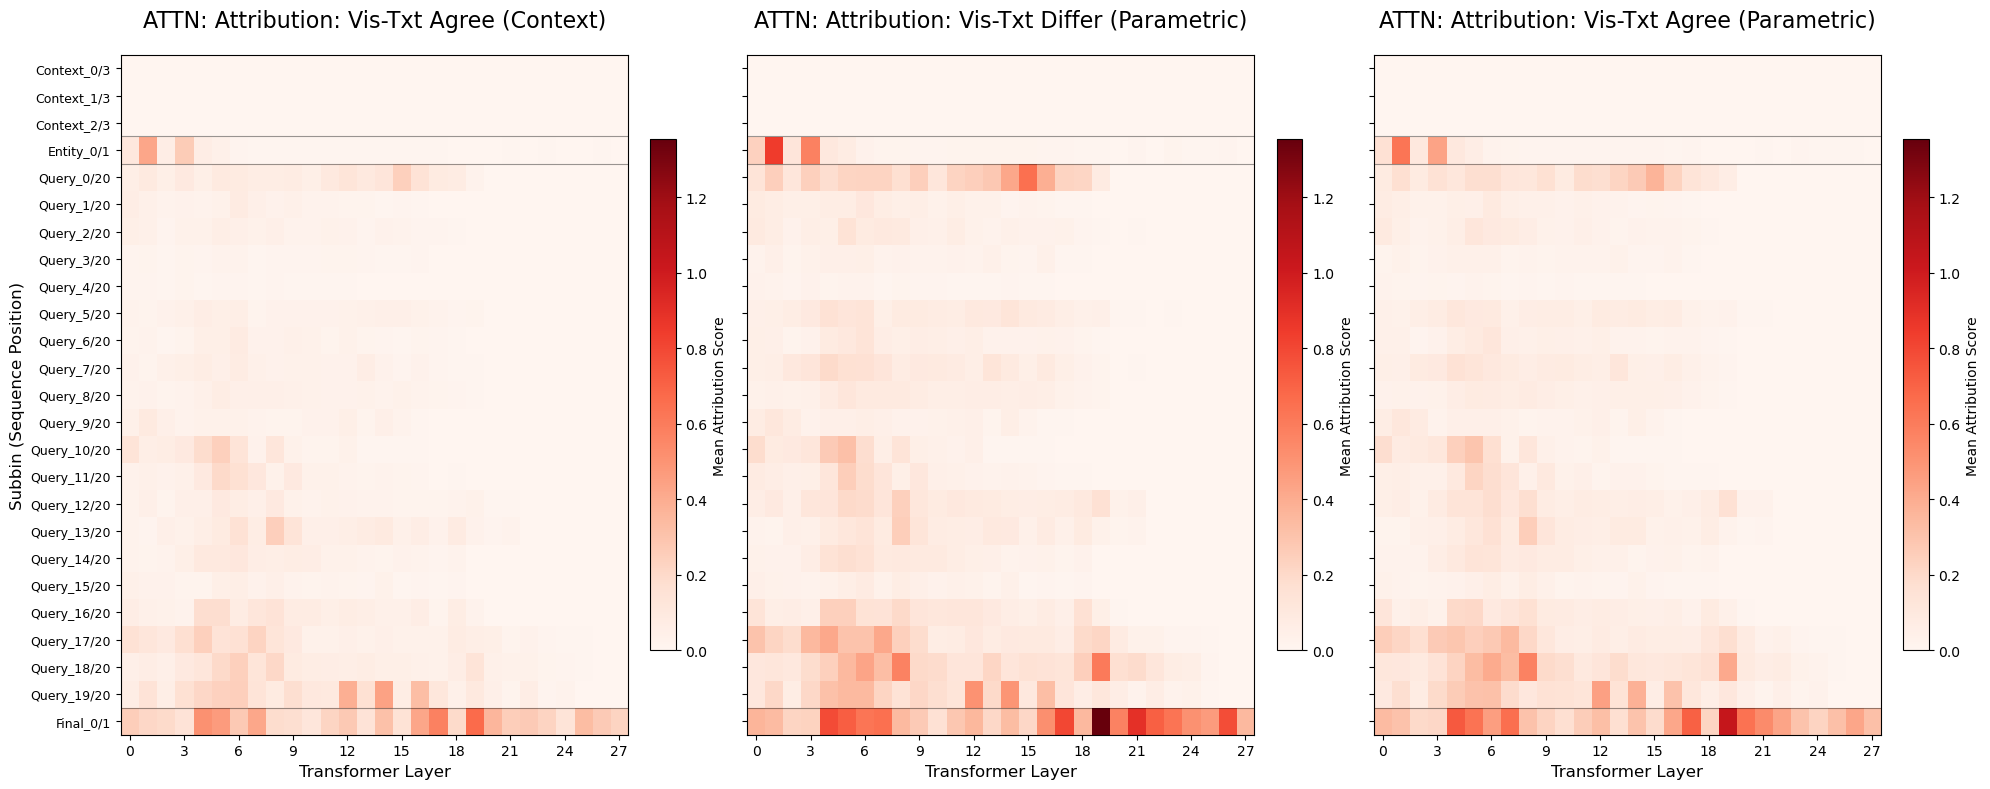

In [32]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_attention.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
#df_vis_correct = df_all[(df_all["Group"] == "VisParam_TextCont") | (df_all["Group"] == "VisTxtParam")]
#df_others = df_all[(df_all["Group"] == "VisTxtCont") | (df_all["Group"] == "VisCont_TextParam")]
df_vis_correct = df_all[(df_all["Group"] == "VisParam_TxtCont")]
df_others = df_all[(df_all["Group"] == "VisTxtCont")]
df_vistxt_param = df_all[(df_all["Group"] == "VisTxtParam")]

mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)
mat_vistxt_param, labels_vistxt_param, info_vistxt_param = process_attribution_data(df_vistxt_param)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)
cmap = "Reds" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis, mat_vistxt_param], 
    [labels_others, labels_vis, labels_vistxt_param], 
    [info_others, info_vis, info_vistxt_param], 
    ["Vis-Txt Agree (Context)", "Vis-Txt Differ (Parametric)", "Vis-Txt Agree (Parametric)"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    #2. Use global_vmax here for both subplots
    im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
                  cmap=cmap, vmin=0, vmax=global_vmax)
    # #POWER NORM SCALE#######
    # gamma = 0.3   # try 0.3–0.6

    # im = ax.imshow(
    #     A,
    #     aspect="auto",
    #     origin="upper",
    #     interpolation="nearest",
    #     cmap=cmap,
    #     norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    # )
    # ###################
    
    ax.set_title(f"ATTN: Attribution: {title}", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    ratio = highest / second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff,
        "Ratio": ratio
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "MLP: Vis_same_txt (Context)")
mlp_diff_stats = get_top_two_analysis(mat_vis, "MLP: Vis_diff_txt (Parametric)")


print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f}, Ratio: {mlp_same_stats['Ratio']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f}, Ratio: {mlp_diff_stats['Ratio']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")
mlp_same_stats = get_top_two_analysis(mat_vistxt_param, "MLP: Vis_same_txt (Parametric)")
print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f}, Ratio: {mlp_same_stats['Ratio']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")

In [33]:
stats_list = [
    (mat_others, info_others, "Vis-Txt Agree (Context)"),
    (mat_vis, info_vis, "Vis-Txt Differ (Parametric)"),
    (mat_vistxt_param, info_vistxt_param, "Vis-Txt Agree (Parametric)")
]

print("--- Entity vs. Last Token Ratio Analysis ---")
for mat, info, name in stats_list:
    res = get_bin_ratio_analysis(mat, info, name)
    print(f"{res['Group']}:")
    print(f"  Max Entity: {res['Max_Entity']:.4f}")
    print(f"  Max Last/Final: {res['Max_Last']:.4f}")
    print(f"  Ratio (Entity/Last): {res['Ratio']:.4f}\n")

--- Entity vs. Last Token Ratio Analysis ---
Vis-Txt Agree (Context):
  Max Entity: 0.4267
  Max Last/Final: 0.6666
  Ratio (Entity/Last): 0.6401

Vis-Txt Differ (Parametric):
  Max Entity: 0.8448
  Max Last/Final: 1.3535
  Ratio (Entity/Last): 0.6242

Vis-Txt Agree (Parametric):
  Max Entity: 0.6286
  Max Last/Final: 1.0369
  Ratio (Entity/Last): 0.6062



# Text attrubutuoin

Found 10 slice files
MLP: Text Answers Context -> Diff: 0.1123, Ratio: 1.6286 (High: 0.2909, 2nd: 0.1786)
MLP: Text Answers Parametric -> Diff: 0.3822, Ratio: 1.8951 (High: 0.8092, 2nd: 0.4270)


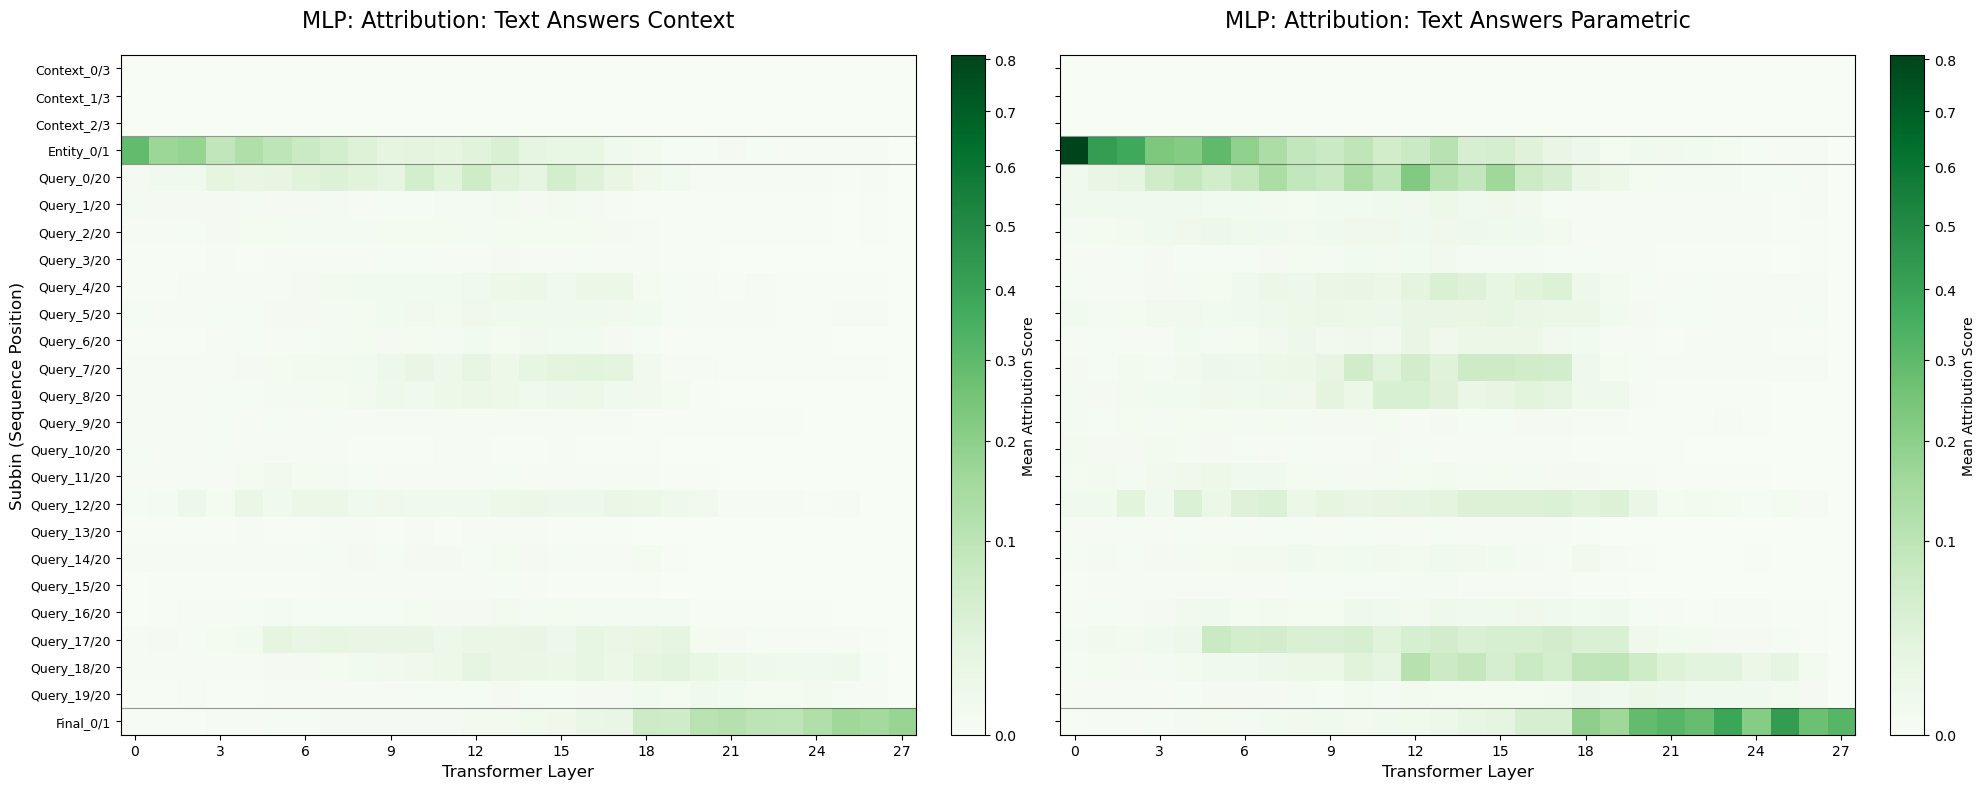

In [34]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_text_slice*of10_mlp.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
df_vis_correct = df_all[(df_all["Group"] == "VisTxtParam") | (df_all["Group"] == "VisCont_TextParam")]
df_others = df_all[(df_all["Group"] == "VisTxtCont") | (df_all["Group"] == "VisParam_TextCont")]
#df_vis_correct = df_all[(df_all["Group"] == "VisParam_TxtCont")]
#df_others = df_all[(df_all["Group"] == "VisTxtCont")]

mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
cmap = "Greens" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis], 
    [labels_others, labels_vis], 
    [info_others, info_vis], 
    ["Text Answers Context", "Text Answers Parametric"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    #2. Use global_vmax here for both subplots
    # im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
    #               cmap=cmap, vmin=0, vmax=global_vmax)
    # #POWER NORM SCALE#######
    gamma = 0.6   # try 0.3–0.6

    im = ax.imshow(
        A,
        aspect="auto",
        origin="upper",
        interpolation="nearest",
        cmap=cmap,
        norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    )
    ###################
    
    ax.set_title(f"MLP: Attribution: {title}", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    ratio = highest / second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff,
        "Ratio": ratio
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "MLP: Text Answers Context")
mlp_diff_stats = get_top_two_analysis(mat_vis, "MLP: Text Answers Parametric")

print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f}, Ratio: {mlp_same_stats['Ratio']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f}, Ratio: {mlp_diff_stats['Ratio']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")

In [35]:
def get_entity_last_ratio(mat, group_name):
    """
    Calculates the ratio: Max(Entity attribution) / Max(Last_token/Final attribution).
    Uses the MultiIndex of the provided matrix to filter bins.
    """
    # 1. Isolate the 'BinParsed' level from the MultiIndex
    bin_labels = mat.index.get_level_values('BinParsed')
    
    # 2. Extract max value from the 'Entity' bin
    entity_data = mat[bin_labels == "Entity"]
    max_entity = entity_data.to_numpy().max() if not entity_data.empty else 0
    
    # 3. Extract max value from 'Last_token' or 'Final' bins
    last_data = mat[bin_labels.isin(["Last_token", "Final"])]
    max_last = last_data.to_numpy().max() if not last_data.empty else 1e-9 # Prevent div by zero
    
    ratio = max_entity / max_last
    
    return {
        "Group": group_name,
        "Max_Entity": max_entity,
        "Max_Last": max_last,
        "Ratio": ratio
    }

# --- Apply Analysis to your matrices ---

# Analysis for the 'Context' group (Text Answers Context)
ratio_context = get_entity_last_ratio(mat_others, "MLP: Text Answers Context")

# Analysis for the 'Parametric' group (Text Answers Parametric)
ratio_parametric = get_entity_last_ratio(mat_vis, "MLP: Text Answers Parametric")

# --- Print Results ---
print("\n--- Entity vs. Last Token Ratio Analysis ---")
for res in [ratio_context, ratio_parametric]:
    print(f"{res['Group']}:")
    print(f"  Max Entity Attribution:   {res['Max_Entity']:.4f}")
    print(f"  Max Last/Final Attribution: {res['Max_Last']:.4f}")
    print(f"  Ratio (Entity / Last):    {res['Ratio']:.4f}\n")


--- Entity vs. Last Token Ratio Analysis ---
MLP: Text Answers Context:
  Max Entity Attribution:   0.2909
  Max Last/Final Attribution: 0.1764
  Ratio (Entity / Last):    1.6492

MLP: Text Answers Parametric:
  Max Entity Attribution:   0.8092
  Max Last/Final Attribution: 0.4270
  Ratio (Entity / Last):    1.8951



Found 10 slice files
ATTN: Text Answers Context -> Diff: 0.2034 (High: 0.4398, 2nd: 0.2364)
ATTN: Text Answers Parametric -> Diff: 1.6110 (High: 2.1088, 2nd: 0.4978)


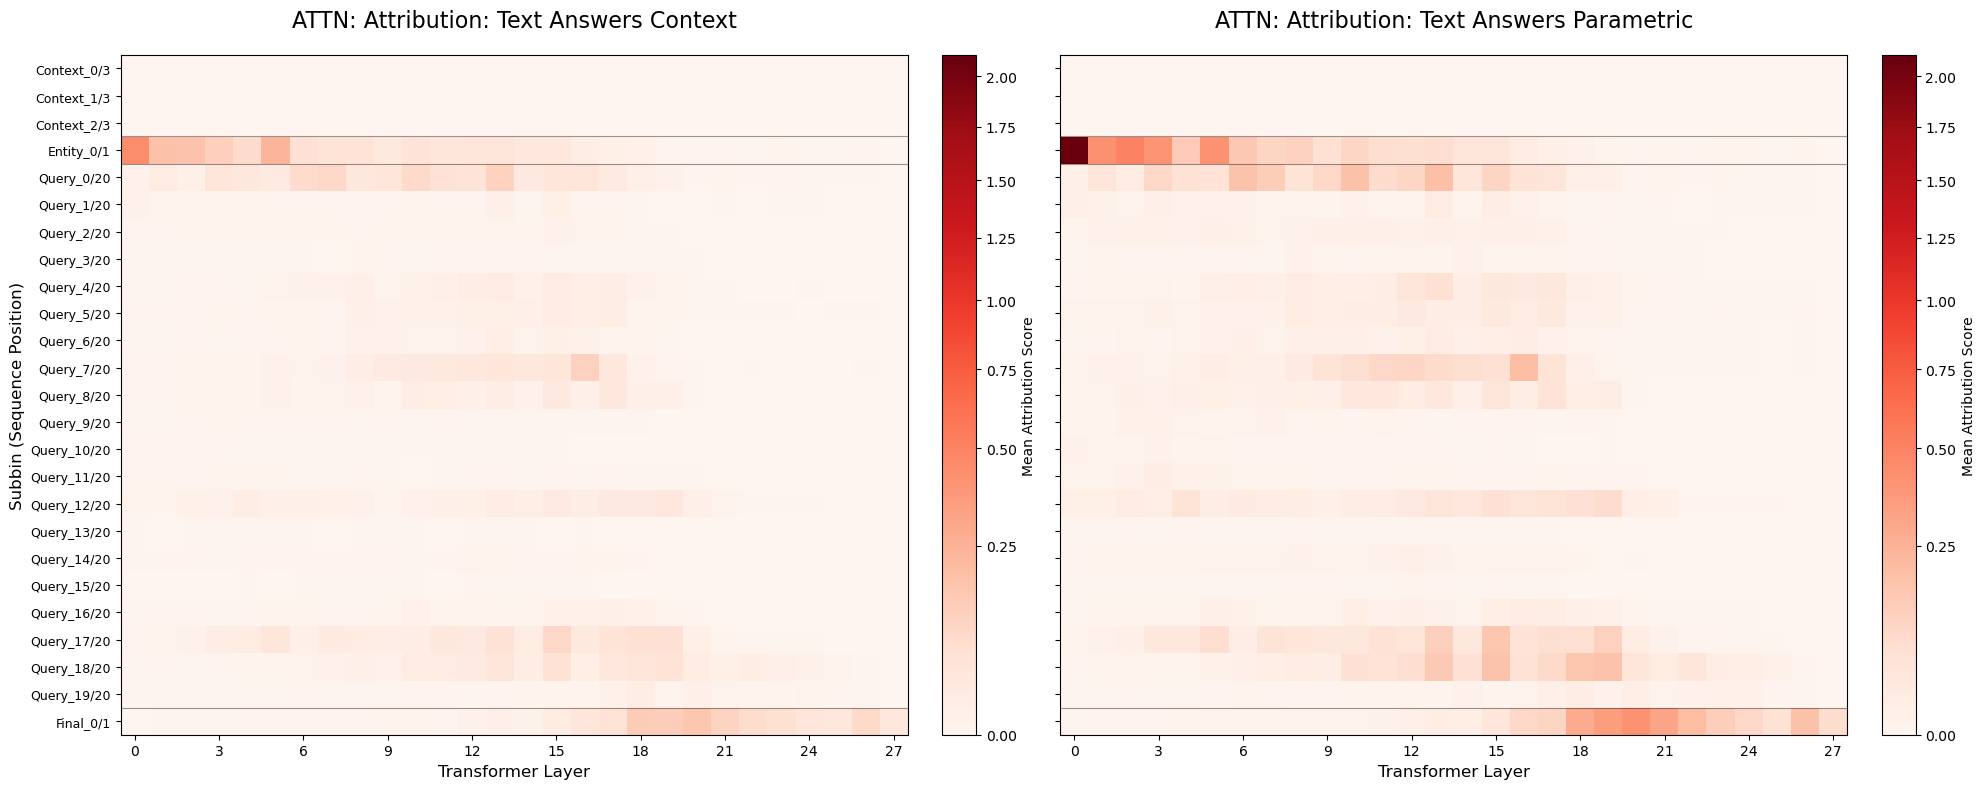

In [36]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_text_slice*of10_attention.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
df_vis_correct = df_all[(df_all["Group"] == "VisTxtParam") | (df_all["Group"] == "VisCont_TextParam")]
df_others = df_all[(df_all["Group"] == "VisTxtCont") | (df_all["Group"] == "VisParam_TextCont")]
#df_vis_correct = df_all[(df_all["Group"] == "VisParam_TxtCont")]
#df_others = df_all[(df_all["Group"] == "VisTxtCont")]

mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
cmap = "Reds" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis], 
    [labels_others, labels_vis], 
    [info_others, info_vis], 
    ["Text Answers Context", "Text Answers Parametric"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    #2. Use global_vmax here for both subplots
    # im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
    #               cmap=cmap, vmin=0, vmax=global_vmax)
    #POWER NORM SCALE#######
    gamma = 0.6   # try 0.3–0.6

    im = ax.imshow(
        A,
        aspect="auto",
        origin="upper",
        interpolation="nearest",
        cmap=cmap,
        norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    )
    ###################
    
    ax.set_title(f"ATTN: Attribution: {title}", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "ATTN: Text Answers Context")
mlp_diff_stats = get_top_two_analysis(mat_vis, "ATTN: Text Answers Parametric")

print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")

In [37]:
ratio_context = get_entity_last_ratio(mat_others, "MLP: Text Answers Context")

# Analysis for the 'Parametric' group (Text Answers Parametric)
ratio_parametric = get_entity_last_ratio(mat_vis, "MLP: Text Answers Parametric")

# --- Print Results ---
print("\n--- Entity vs. Last Token Ratio Analysis ---")
for res in [ratio_context, ratio_parametric]:
    print(f"{res['Group']}:")
    print(f"  Max Entity Attribution:   {res['Max_Entity']:.4f}")
    print(f"  Max Last/Final Attribution: {res['Max_Last']:.4f}")
    print(f"  Ratio (Entity / Last):    {res['Ratio']:.4f}\n")


--- Entity vs. Last Token Ratio Analysis ---
MLP: Text Answers Context:
  Max Entity Attribution:   0.4398
  Max Last/Final Attribution: 0.1599
  Ratio (Entity / Last):    2.7506

MLP: Text Answers Parametric:
  Max Entity Attribution:   2.1088
  Max Last/Final Attribution: 0.4071
  Ratio (Entity / Last):    5.1798



In [38]:


# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_mlp.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
df_vis_correct = df_all[(df_all["Group"] == "VisParam_TxtCont")]
df_others = df_all[(df_all["Group"] == "VisTxtCont")]
df_vis_correct


Found 10 slice files


,ID,Entity,Category,Group,Layer,Component,Bin,Subbin,Attribution
8400,138,Kevin James,Career_error,VisParam_TxtCont,0,mlp,Context,Context_0/3,0.000000
8401,138,Kevin James,Career_error,VisParam_TxtCont,0,mlp,Context,Context_1/3,0.000000
8402,138,Kevin James,Career_error,VisParam_TxtCont,0,mlp,Context,Context_2/3,0.000000
8403,138,Kevin James,Career_error,VisParam_TxtCont,0,mlp,Entity,Entity_0/1,0.460693
8404,138,Kevin James,Career_error,VisParam_TxtCont,0,mlp,Final,Final_0/1,0.125854
...,...,...,...,...,...,...,...,...,...
447995,134,Winona Ryder,Career_error,VisParam_TxtCont,27,mlp,Query,Query_5/20,0.000000
447996,134,Winona Ryder,Career_error,VisParam_TxtCont,27,mlp,Query,Query_6/20,0.000000
447997,134,Winona Ryder,Career_error,VisParam_TxtCont,27,mlp,Query,Query_7/20,0.000000
447998,134,Winona Ryder,Career_error,VisParam_TxtCont,27,mlp,Query,Query_8/20,0.000000


# No conflict

Found 10 slice files


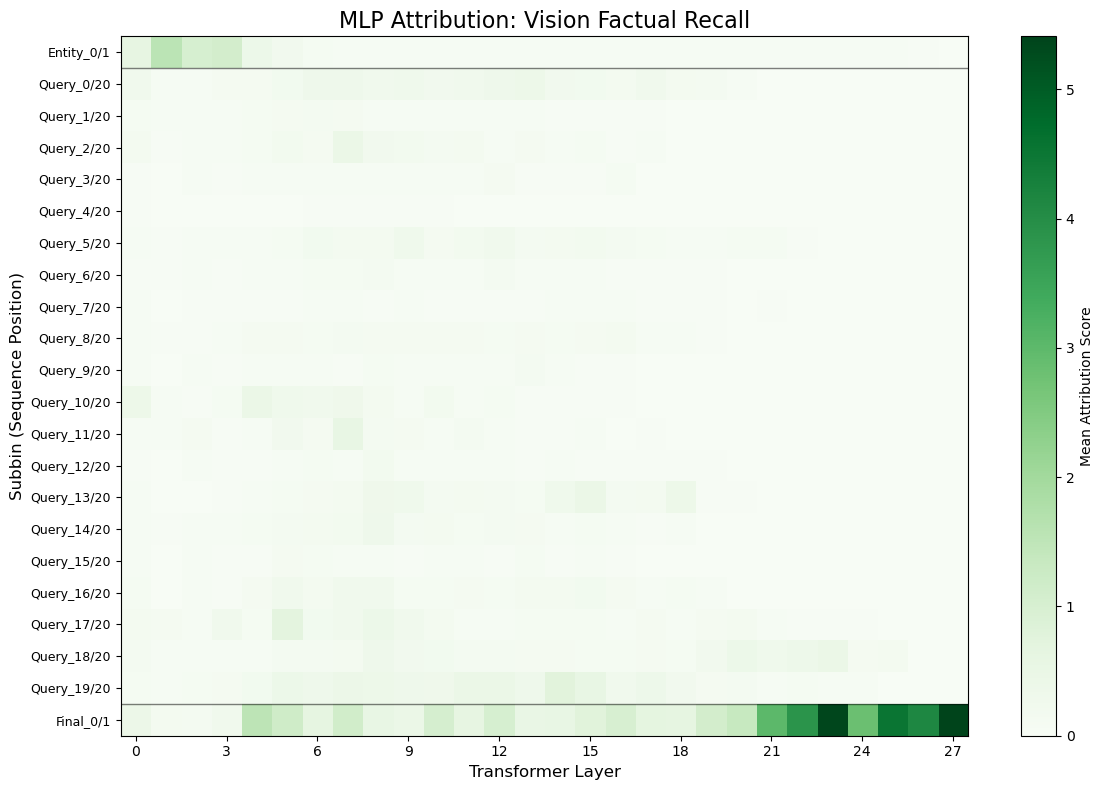

Max Attribution: 5.4100


In [39]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_no_cnflict_slice*of10_mlp.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")

# Combine all data and filter for the target category
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']

def process_attribution_data_unified(df):
    """Parses and aggregates attribution scores, excluding Context."""
    # Regex to parse bin names and indices
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    # Apply parsing
    parsed = df["Subbin"].apply(parse_subbin)
    df = df.copy()
    df["BinParsed"] = parsed.apply(lambda x: x[0])
    df["SubIdx"]    = parsed.apply(lambda x: x[1])
    df["NSub"]      = parsed.apply(lambda x: x[2])
    
    # EXCLUSION: Filter out "Context" and "Other"
    target_bins = ["Entity", "Query", "Last_token", "Final"]
    df = df[df["BinParsed"].isin(target_bins)].copy()

    # Aggregate across all groups
    agg = df.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    
    # Define display order
    bin_order = {name: i for i, name in enumerate(target_bins)}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    # Prepare matrix indexing
    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    # Pivot into Layer vs Subbin matrix
    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Process and Plot ---
mat_combined, labels, info = process_attribution_data_unified(df_all)

plt.figure(figsize=(12, 8))
layers = mat_combined.columns.to_numpy()
A = mat_combined.to_numpy()

im = plt.imshow(A, aspect="auto", origin="upper", interpolation="nearest", cmap="Greens")

# Formatting
plt.title("MLP Attribution: Vision Factual Recall", fontsize=16)
plt.xlabel("Transformer Layer", fontsize=12)
plt.ylabel("Subbin (Sequence Position)", fontsize=12)

# X-axis ticks
xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
plt.xticks(xticks, layers[xticks])

# Y-axis labels
plt.yticks(np.arange(len(labels)), labels, fontsize=9)

# Visual Separators for Bins
start_rows = []
for b in ["Entity", "Query", "Last_token", "Final"]:
    idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
    if len(idxs):
        start_rows.append(int(idxs.min()))
for r in start_rows[1:]:
    plt.axhline(r - 0.5, color="black", linewidth=1.0, alpha=0.5)

plt.colorbar(im, label="Mean Attribution Score")
plt.tight_layout()
#plt.savefig("unified_attribution_plot.png")
plt.show()

# Quick summary statistics
highest_val = np.max(A)
print(f"Max Attribution: {highest_val:.4f}")

Found 10 slice files


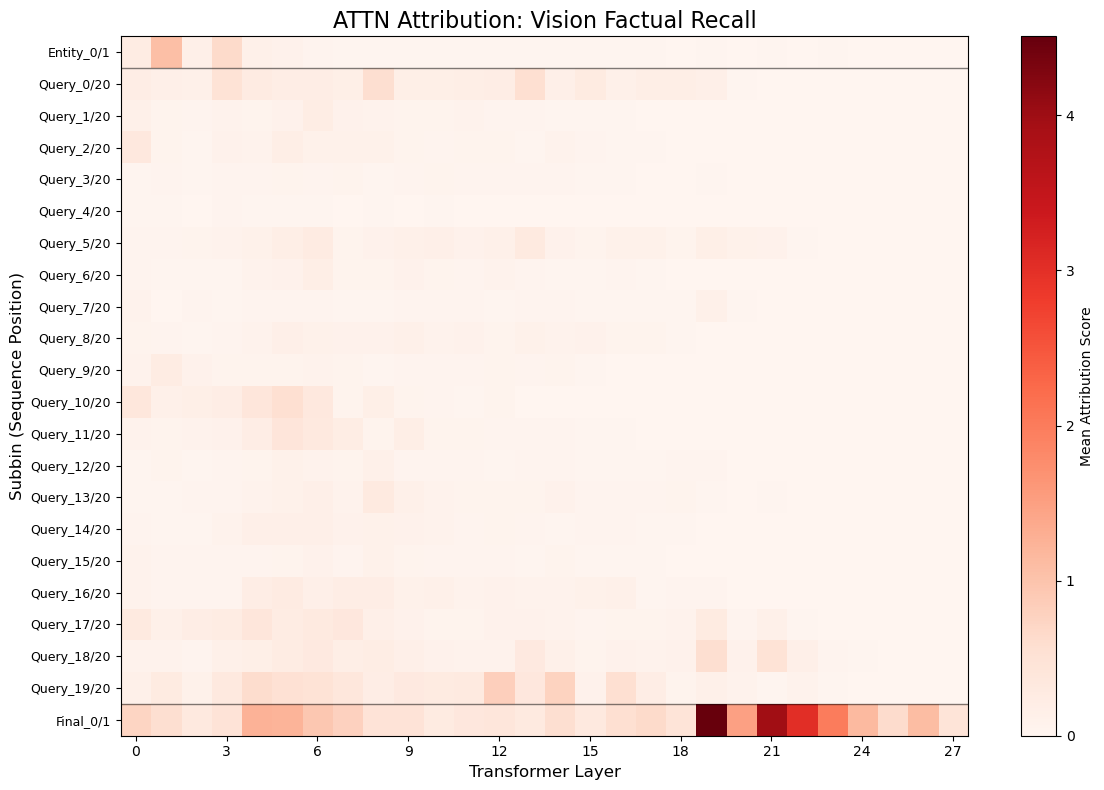

Max Attribution: 4.5091


In [40]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_no_cnflict_slice*of10_attention.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")

# Combine all data and filter for the target category
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']

def process_attribution_data_unified(df):
    """Parses and aggregates attribution scores, excluding Context."""
    # Regex to parse bin names and indices
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    # Apply parsing
    parsed = df["Subbin"].apply(parse_subbin)
    df = df.copy()
    df["BinParsed"] = parsed.apply(lambda x: x[0])
    df["SubIdx"]    = parsed.apply(lambda x: x[1])
    df["NSub"]      = parsed.apply(lambda x: x[2])
    
    # EXCLUSION: Filter out "Context" and "Other"
    target_bins = ["Entity", "Query", "Last_token", "Final"]
    df = df[df["BinParsed"].isin(target_bins)].copy()

    # Aggregate across all groups
    agg = df.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    
    # Define display order
    bin_order = {name: i for i, name in enumerate(target_bins)}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    # Prepare matrix indexing
    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    # Pivot into Layer vs Subbin matrix
    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Process and Plot ---
mat_combined, labels, info = process_attribution_data_unified(df_all)

plt.figure(figsize=(12, 8))
layers = mat_combined.columns.to_numpy()
A = mat_combined.to_numpy()

im = plt.imshow(A, aspect="auto", origin="upper", interpolation="nearest", cmap="Reds")

# Formatting
plt.title("ATTN Attribution: Vision Factual Recall", fontsize=16)
plt.xlabel("Transformer Layer", fontsize=12)
plt.ylabel("Subbin (Sequence Position)", fontsize=12)

# X-axis ticks
xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
plt.xticks(xticks, layers[xticks])

# Y-axis labels
plt.yticks(np.arange(len(labels)), labels, fontsize=9)

# Visual Separators for Bins
start_rows = []
for b in ["Entity", "Query", "Last_token", "Final"]:
    idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
    if len(idxs):
        start_rows.append(int(idxs.min()))
for r in start_rows[1:]:
    plt.axhline(r - 0.5, color="black", linewidth=1.0, alpha=0.5)

plt.colorbar(im, label="Mean Attribution Score")
plt.tight_layout()
#plt.savefig("unified_attribution_plot.png")
plt.show()

# Quick summary statistics
highest_val = np.max(A)
print(f"Max Attribution: {highest_val:.4f}")

Found 10 slice files


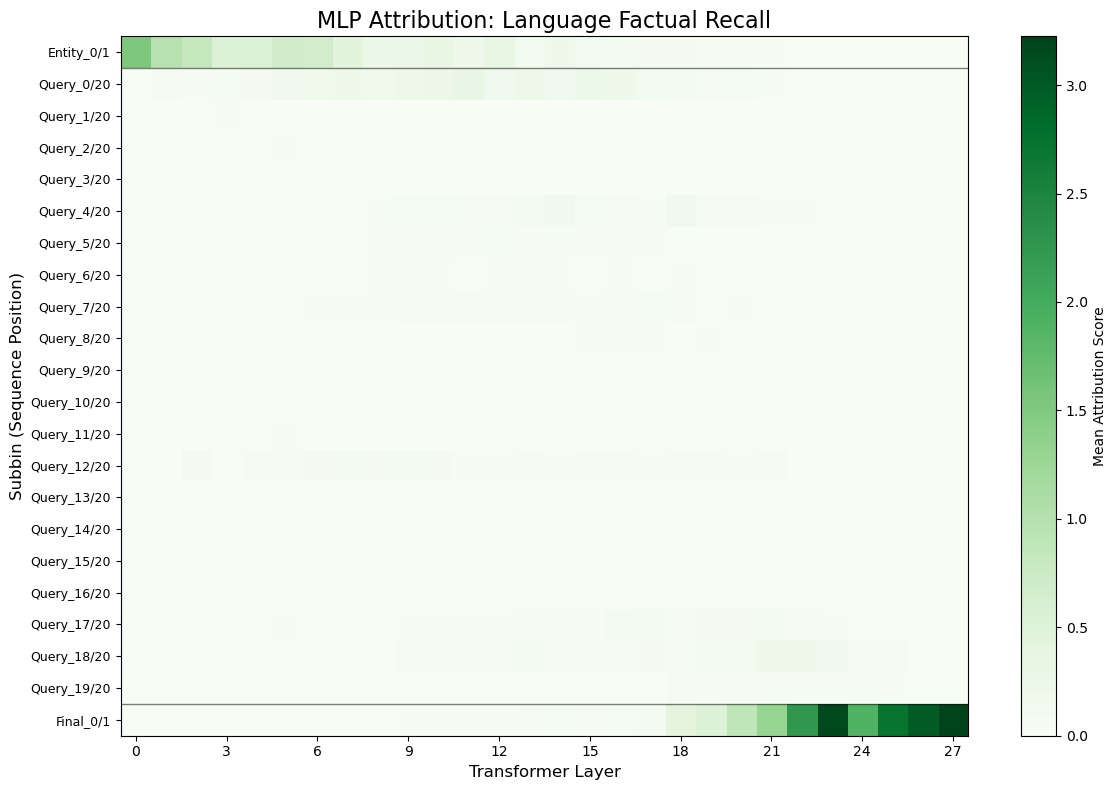

Max Attribution: 3.2248


In [41]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_no_cnflict_text_slice*of10_mlp.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")

# Combine all data and filter for the target category
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']

def process_attribution_data_unified(df):
    """Parses and aggregates attribution scores, excluding Context."""
    # Regex to parse bin names and indices
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    # Apply parsing
    parsed = df["Subbin"].apply(parse_subbin)
    df = df.copy()
    df["BinParsed"] = parsed.apply(lambda x: x[0])
    df["SubIdx"]    = parsed.apply(lambda x: x[1])
    df["NSub"]      = parsed.apply(lambda x: x[2])
    
    # EXCLUSION: Filter out "Context" and "Other"
    target_bins = ["Entity", "Query", "Last_token", "Final"]
    df = df[df["BinParsed"].isin(target_bins)].copy()

    # Aggregate across all groups
    agg = df.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    
    # Define display order
    bin_order = {name: i for i, name in enumerate(target_bins)}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    # Prepare matrix indexing
    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    # Pivot into Layer vs Subbin matrix
    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Process and Plot ---
mat_combined, labels, info = process_attribution_data_unified(df_all)

plt.figure(figsize=(12, 8))
layers = mat_combined.columns.to_numpy()
A = mat_combined.to_numpy()

im = plt.imshow(A, aspect="auto", origin="upper", interpolation="nearest", cmap="Greens")

# Formatting
plt.title("MLP Attribution: Language Factual Recall", fontsize=16)
plt.xlabel("Transformer Layer", fontsize=12)
plt.ylabel("Subbin (Sequence Position)", fontsize=12)

# X-axis ticks
xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
plt.xticks(xticks, layers[xticks])

# Y-axis labels
plt.yticks(np.arange(len(labels)), labels, fontsize=9)

# Visual Separators for Bins
start_rows = []
for b in ["Entity", "Query", "Last_token", "Final"]:
    idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
    if len(idxs):
        start_rows.append(int(idxs.min()))
for r in start_rows[1:]:
    plt.axhline(r - 0.5, color="black", linewidth=1.0, alpha=0.5)

plt.colorbar(im, label="Mean Attribution Score")
plt.tight_layout()
#plt.savefig("unified_attribution_plot.png")
plt.show()

# Quick summary statistics
highest_val = np.max(A)
print(f"Max Attribution: {highest_val:.4f}")

Found 10 slice files


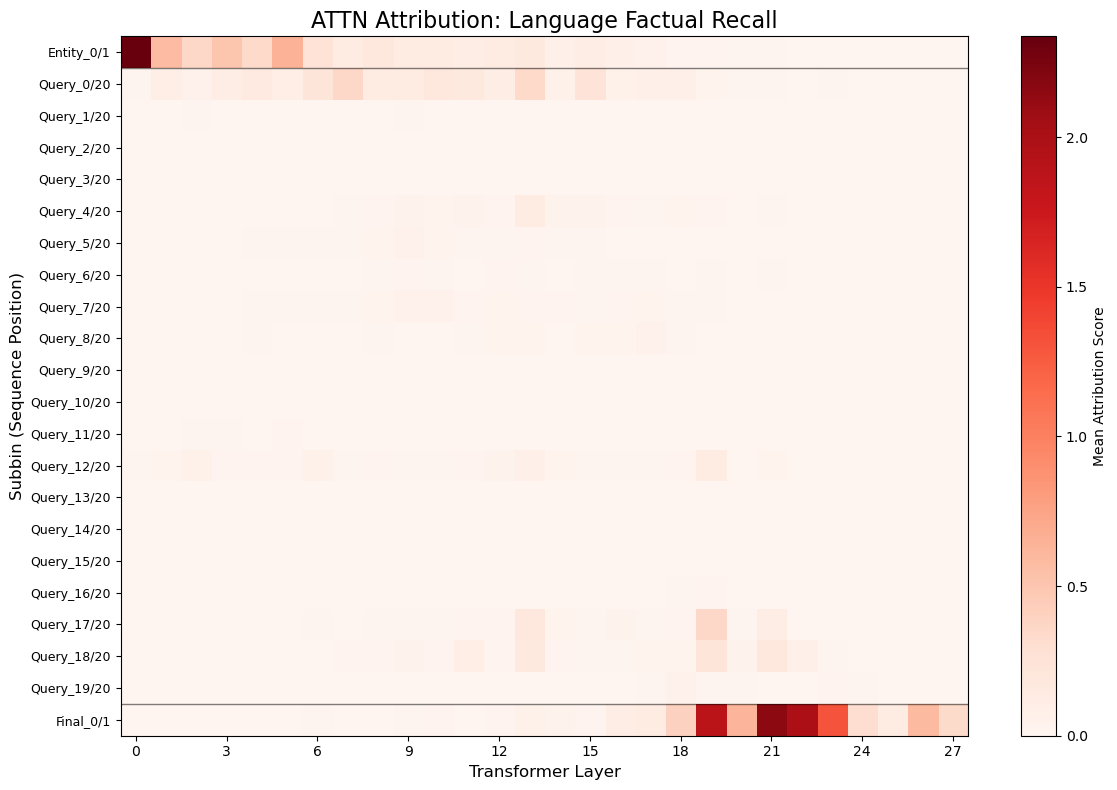

Max Attribution: 2.3364


In [42]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/FRQ/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_no_cnflict_text_slice*of10_attention.csv")
files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")

# Combine all data and filter for the target category
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']

def process_attribution_data_unified(df):
    """Parses and aggregates attribution scores, excluding Context."""
    # Regex to parse bin names and indices
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    # Apply parsing
    parsed = df["Subbin"].apply(parse_subbin)
    df = df.copy()
    df["BinParsed"] = parsed.apply(lambda x: x[0])
    df["SubIdx"]    = parsed.apply(lambda x: x[1])
    df["NSub"]      = parsed.apply(lambda x: x[2])
    
    # EXCLUSION: Filter out "Context" and "Other"
    target_bins = ["Entity", "Query", "Last_token", "Final"]
    df = df[df["BinParsed"].isin(target_bins)].copy()

    # Aggregate across all groups
    agg = df.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    
    # Define display order
    bin_order = {name: i for i, name in enumerate(target_bins)}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    # Prepare matrix indexing
    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    # Pivot into Layer vs Subbin matrix
    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Process and Plot ---
mat_combined, labels, info = process_attribution_data_unified(df_all)

plt.figure(figsize=(12, 8))
layers = mat_combined.columns.to_numpy()
A = mat_combined.to_numpy()

im = plt.imshow(A, aspect="auto", origin="upper", interpolation="nearest", cmap="Reds")

# Formatting
plt.title("ATTN Attribution: Language Factual Recall", fontsize=16)
plt.xlabel("Transformer Layer", fontsize=12)
plt.ylabel("Subbin (Sequence Position)", fontsize=12)

# X-axis ticks
xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
plt.xticks(xticks, layers[xticks])

# Y-axis labels
plt.yticks(np.arange(len(labels)), labels, fontsize=9)

# Visual Separators for Bins
start_rows = []
for b in ["Entity", "Query", "Last_token", "Final"]:
    idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
    if len(idxs):
        start_rows.append(int(idxs.min()))
for r in start_rows[1:]:
    plt.axhline(r - 0.5, color="black", linewidth=1.0, alpha=0.5)

plt.colorbar(im, label="Mean Attribution Score")
plt.tight_layout()
#plt.savefig("unified_attribution_plot.png")
plt.show()

# Quick summary statistics
highest_val = np.max(A)
print(f"Max Attribution: {highest_val:.4f}")